## Image Classification with Stacked Ensemble Models
#
This section includes necessary imports and setup for an advanced image classification task using stacked ensemble models. It utilizes various machine learning libraries such as scikit-learn for model training and evaluation, and XGBoost for powerful ensemble learning. Additionally, the code suppresses warnings for cleaner output.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)

#

## Image Processing and Classification Functions

This section defines several functions for image processing and classification:

1. `imread(img_path)`: Reads an image from a given path and converts it from BGR to RGB color space.
2. `imshow(img, figsize)`: Displays an image using Matplotlib with an optional figure size.
3. `rgb2bin(img_rgb)`: Converts an RGB image to a binary image using Otsu's thresholding method.
4. `find_best_contour(img_rgb)`: Finds the largest contour in an RGB image based on area.
5. `draw_contours(img, contours, index, color, thickness)`: Draws specified contours on an image.
6. `chain_hist(img_rgb)`: Creates a histogram of chain code directions from the largest contour in an image.
7. `create_df(data_path)`: Creates a DataFrame from a dataset directory, categorizing images by class.
8. `extract_features(img_paths)`: Extracts features from images at given paths, returning a NumPy array.
9. `predict(model, img)`: Predicts the class of a given image using a trained model.
10. `detect_connected_components(img, width_range, height_range)`: Detects connected components in an image, predicts their classes, and annotates the image with these predictions.

These functions are essential for preprocessing images, extracting features, and utilizing a trained model for image classification tasks.


In [2]:
# Function to read and convert an image from BGR to RGB
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Function to display an image
def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()

# Function to convert an RGB image to binary
def rgb2bin(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img_bin

# Function to find the largest contour in an image
def find_best_contour(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    best_contour = max(contours, key=cv2.contourArea)
    return best_contour

# Function to draw contours on an image
def draw_contours(img, contours, index=-1, color=(255, 0, 0), thickness=2):
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)

# Function to create a histogram of chain code directions
def chain_hist(img_rgb):
    best_contour = find_best_contour(img_rgb)
    lookup_table = {(1, 0): 0, (1, -1): 1, (0, -1): 2, (-1, -1): 3,
                    (-1, 0): 4, (-1, 1): 5, (0, 1): 6, (1, 1): 7}
    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        hist[code] += 1
    return hist/hist.sum()

# Function to create a dataframe from the dataset directory
def create_df(data_path):
    dic = {'circle': 0, 'square': 1, 'star': 2, 'triangle': 3}
    df = []
    for class_name, class_value in dic.items():
        class_folder = os.path.join(data_path, class_name)
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            if f_path.lower().endswith('.png'):
                df.append([f_path, class_value])
    df = pd.DataFrame(df, columns=['path', 'output'])
    return df

# Function to extract features from the image paths
def extract_features(img_paths):
    n = len(img_paths)
    X = np.zeros((n, 8))
    for i in tqdm(range(n)):
        f_path = img_paths[i]
        img = imread(f_path)
        features = chain_hist(img)
        X[i] = features
    return X

# Function to predict the class of a given image
def predict(model, img):
    names = ['circle', 'square', 'star', 'triangle']
    features = chain_hist(img)
    prediction = model.predict([features])[0]
    return names[prediction]

# Detect connected components and predict labels
def detect_connected_components(img, width_range, height_range):
    binary_img = rgb2bin(img)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=4)
    centroids = centroids.astype(int)
    img_copy = img.copy()
    for i in range(1, nLabels):
        x, y, w, h, _ = stats[i]
        (cx, cy) = centroids[i]
        acceptWidth = width_range[0] < w < width_range[1]
        acceptHeight = height_range[0] < h < height_range[1]
        if acceptWidth and acceptHeight:
            shape = img[y:y+h, x:x+w]
            label = predict(stacked_model, shape)
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(img_copy, label, (x, y-4), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (255, 0, 0))
    imshow(img_copy, figsize=(10, 10))


#

## Example Usage of Image Processing Functions

In this section, we demonstrate the application of the previously defined functions. We will:

1. Read an image of a 'star' shape from a specified path.
2. Apply the `chain_hist` function to this image to create a histogram of chain code directions.
3. Display the resulting chain code histogram.

This example helps illustrate how the functions work in a real-world scenario.


In [3]:
# Example usage
img = imread("C:\\Users\\Abdien\\ABDIEN\\Study\\CV\\SHAPES\\shapes\\star\\0.png")
chain_histogram = chain_hist(img)
chain_histogram

array([0.15909091, 0.08333333, 0.17929293, 0.05555556, 0.20454545,
       0.05050505, 0.1969697 , 0.07070707])

#

## Creating a DataFrame from the Image Dataset

In this part, we perform the following steps:

1. Define the path to the image dataset.
2. Utilize the `create_df` function to build a DataFrame. This DataFrame will contain two columns: 
   - 'path': The file paths of the images.
   - 'output': The corresponding labels of the images (e.g., circle, square, star, triangle).
3. Display the first five entries of the DataFrame for a quick preview.

This process is essential for organizing our dataset, making it more accessible and structured for further analysis and model training.


In [4]:
# Path to the dataset
dataset_path = "shapes"

# Create a DataFrame with image paths and their labels
df = create_df(dataset_path)
df.head(5)

,path,output
0,shapes\circle\0.png,0
1,shapes\circle\1.png,0
2,shapes\circle\10.png,0
3,shapes\circle\100.png,0
4,shapes\circle\1000.png,0


#

## Feature Extraction and Dataset Splitting

Here, we perform critical steps in preparing our data for the machine learning model:

1. **Feature Extraction**:
   - We call the `extract_features` function on our image paths to obtain a feature array `x`. 
   - This function applies the previously defined `chain_hist` function to each image and aggregates the results into a feature matrix.

2. **Extracting Labels**:
   - We assign the 'output' column of our DataFrame to `y`, which contains the labels for our images.

3. **Splitting the Dataset**:
   - The dataset is split into training and testing sets using `train_test_split` from scikit-learn.
   - We allocate 70% of the data for training (`x_train`, `y_train`) and 30% for testing (`x_test`, `y_test`).
   - The split is done randomly with a set seed (`random_state=22`) for reproducibility.

These steps are crucial for training a machine learning model as they ensure that the model is tested on unseen data, evaluating its performance effectively.


In [5]:
# Extract features from the images
x = extract_features(df['path'])

# Labels
y = df['output']

# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=22)


100%|██████████████████████████████████████████████████████████████████████████| 14970/14970 [00:13<00:00, 1105.08it/s]


#

## Stacking Ensemble Model Setup and Evaluation

In this section, we configure and train a Stacking Ensemble Model for improved classification performance:

1. **Defining Base Models**:
   - A collection of diverse and robust classifiers (`RandomForestClassifier`, `XGBClassifier`, `ExtraTreesClassifier`) are chosen as base models, each with 200 estimators.

2. **Meta-Learner Definition**:
   - `GradientBoostingClassifier` with 50 estimators is used as the meta-learner, which will learn to effectively combine the predictions from the base models.

3. **Initializing and Training the Stacking Classifier**:
   - The `StackingClassifier` is initialized with the specified base models and meta-learner, employing all available CPU cores (`n_jobs=-1`) and 5-fold cross-validation (`cv=5`).
   - The model is trained using the training data (`x_train`, `y_train`).

4. **Model Evaluation**:
   - The trained Stacking Classifier is evaluated on both the training and test datasets.
   - The accuracy scores for both training and test sets are printed to assess the model's performance.

This stacked approach aims to harness the strengths of individual models and improve overall predictive accuracy.


In [6]:

# Define the base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200)),  # Random Forest
    ('xgb', XGBClassifier(n_estimators=200)),          # XGBoost
    ('et', ExtraTreesClassifier(n_estimators=200))     # Extra Trees
]

# Define the meta-learner
meta_learner = GradientBoostingClassifier(n_estimators=50)  # Gradient Boosting

# Initialize the Stacking model
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, n_jobs=-1, cv=5)

# Train the Stacking model
stacked_model.fit(x_train, y_train)

# Evaluate the model
y_pred_train = stacked_model.predict(x_train)
y_pred_test = stacked_model.predict(x_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

Training Accuracy: 0.9945724782899131
Testing Accuracy: 0.9515698062792252


#

## Example: Displaying an Image

This example demonstrates how to read and display an image:

1. The `imread` function is used to load an image named "shapes.png" into the variable `test_img`.
2. We then display this image using the `imshow` function.

This provides a visual verification that our image loading and displaying functions are working correctly.


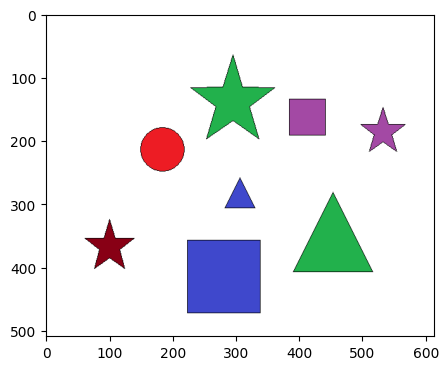

In [7]:
# Example usage
test_img = imread("shapes.png")
imshow(test_img)

#

## Detecting and Labeling Connected Components in an Image

In this part, we apply the `detect_connected_components` function to the loaded image:

1. **Function Application**:
   - The `detect_connected_components` function is called on `test_img` with specified width and height ranges set to (1, 600).
   - This function detects individual shapes in the image and classifies them based on their size.

2. **Operation Details**:
   - The function first converts the image to a binary format.
   - It then identifies connected components (individual shapes) within the specified size range.
   - For each detected shape, the function predicts its class (e.g., circle, square, star, triangle) using the trained stacked model.
   - Finally, it draws rectangles around these shapes and annotates them with their predicted labels.

This step illustrates the ability of our model to not only identify different shapes in a complex image but also to classify each shape accurately.


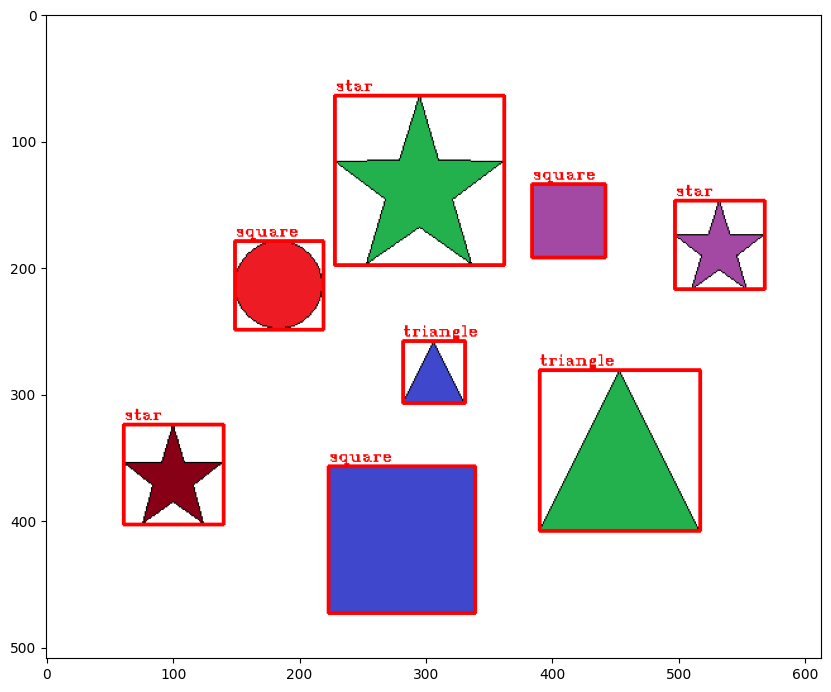

In [8]:
detect_connected_components(test_img, width_range=(1, 600), height_range=(1, 600))